In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

This post is the second part of the discussion of classifying climates. In the previous [one](https://bhornung.github.io/python/2019/01/29/climate-classification.html) we explored the structure of the data and optimised a k nearest neighbour classifier. The objectives this time are

* build a data pipeline
* use neural networks to classify the climate data

## The Data

The data comprises of 24 numerical records and a label. The first twelve dimensions of the numerals are the monthly mean temperature in celsius degrees times ten. The second half lists the monthly mean precipitation in milimetres. 

### Data flow

Much like in a real world, scenario we do not posses the entire dataset in advance. Each step in the data pipeline therefore has to be reuseable. In the previous post the data was preprocessed before the feature engineering step. This time, the preprocessing steps are incorporated in the pipeline.

## Preprocessing

### Transformation

The temperature and precipitation data are in different ranges and heavily riddled with outliers. We therefore use Yeo--Johnson transforms separately on the two sets.  

#### Power transform on flattened arrays

All features in a set should undergo identical transformation to preserve the relative positions of the data e.g. July's temperatures should be transformed exactly in the same way as December's temperatures are. For the transformer classes operate along each dimension, we write a wrapper which takes a 2D array and flattens it to **1D** before the fitting and transformation. It restores the original shape of the transformed array afterwards. The wrapper is implemented in the `create_flat_transformer` function below. It takes a transformer class and decorates its `fit`, `transform` and `fit_transform` methods.

In [2]:
import numpy as np

In [3]:
def create_flat_transformer(transformer):
    """
    Wrapper to perform the transformation on the flattened input array to 1D
    The X argument is transformmed:
        (n_samples, n_features) --> (n_samples * n_features, 1)
        
    It preserves the methods and attributes of the underlying estimator.
    Parameters:
        transformer (object) : should implement the methods
            fit(X[, y])
            transform(X)
            
    Returns
        inner (object) : class with decorated methods.
    """
    
    class inner(transformer):
        def __init__(self, **kwargs):
            """
            Instantiates a transformer object.
            """
             
            # sanity check 
            required_attrs = ['fit', 'transform', 'fit_transform']
            for attr in required_attrs:
                if getattr(super(), attr, None) is None:
                    raise AttributeError("transformer should have {0} attribute".format(attr))
             
            # use underlying estimators machinery
            super().__init__( **kwargs)

        def fit(self, X, y = None):
            """
            1. flattens a 2D array
            2. creates rule for transform on the flattened array.
            """
            
            super().fit(X.reshape(-1, 1), y)
            
            return self
   
        def transform(self, X):
            """
            1. flattens a 2D array
            2. transforms it
            3. restores it ot its original shape
            """
            
            X_t = super().transform(X.reshape(-1, 1))
            return X_t.reshape(-1, X.shape[1])
        
        def fit_transform(self, X, y = None):
            """
            Fits and transforms 2D array via flattening.
            """
            
            x_t = super().fit_transform(X.reshape(-1, 1), y)
            return x_t.reshape(-1, X.shape[1])

    return inner

#### Power transform on split data

We should remember ourselves that the temperature and precipitation data have to be scaled separately.

For this end, using one transformer instance avoiding splitting the data, we write a class which applies transormers to subsets of features. It is akin to [`FeatureUnion`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html). The main only difference is, that a certain transform is applied to a specified section of the dimensions as opposed to the entire data. This is implemented as the `SegmentedFeatureUnion` class below. We are going to subclass the aforementioned `FeatureUnion` class, so that its methods can safely be reused.

In [42]:
from sklearn.pipeline import FeatureUnion, _fit_one_transformer, _transform_one
from sklearn.utils._joblib import delayed, Parallel

class SegmentedFeatureUnion(FeatureUnion):
    """
    Applies transformers to selections of features.
    Class based on sklearn.pipeline FeatureUnion
    """
    
    def __init__(self, transformer_list, n_jobs = None,
                 transformer_weights = None, transformer_ranges = None):
        """
        Parameters:
            transformer_list ([object]) : list of objects that implements the methods 
                fit : fit(X[, y])
                transform : transform(X, [,y])
            transformer_ranges ([np.ndarray]) : list of indices to which the transformers are applied. 
        """
        
        super().__init__(transformer_list, 
                         n_jobs = n_jobs, 
                         transformer_weights = transformer_weights)
        
        self.transformer_ranges = transformer_ranges

    def _iter(self):
        """
        Generate (name, trans, weight, transformer_range) tuples excluding None and
        'drop' transformers.
        """
        get_weight = (self.transformer_weights or {}).get
        
        return ((name, trans, get_weight(name), transformer_range)
                    for (name, trans), transformer_range in zip(self.transformer_list, self.transformer_ranges)
                        if trans is not None and trans != 'drop')
    
    def fit(self, X, y = None):
        """
        Fit all transformers using X.
        
        Parameters:
            X (np.ndarray[n_samples, n_features]) : data to be transformed
            y ({np.ndarray[n_samples], None}) : target variable, usually not used
            
        Returns:
            self (SegmentedFeatureUnion) : this estimator
        """
        
        self.transformer_list = list(self.transformer_list)
        self._validate_transformers()
        transformers = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_one_transformer)(trans, X[:, transform_range], y)
                for _, trans, _, transform_range in self._iter())
        
        # save fitted transformers --> used in self._iter
        self._update_transformer_list(transformers)
        
        return self

    def transform(self, X, y = None):
        """
        Transform X separately by each transformer, concatenate results.
        Parameters
            X (np.ndarray[n_samples, n_features]) : data to be transformed
            y ({np.ndarray[n_samples], None}) : ignored
            
        Returns
            X_t : array-like or sparse matrix, shape (n_samples, sum_n_components)
            hstack of results of transformers. sum_n_components is the
            sum of n_components (output dimension) over transformers.
        """
        
        x_t = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(trans, X[:, transform_range], None, weight)
                for name, trans, weight, transform_range in self._iter())
        
        # stack arrays
        X_t = np.hstack(X_t)
        
        return X_t
    
    def fit_transform(self, X, y = None):
        """
        Override parents fittransform.
        """
        return self.fit(X, y).transform(X, y)

#### Testing

We can now transform the data according to the following recipe
* split features to temperature and precipitation subspaces
* flatten each subspace
* power transform each flattened arrays
* mould array to original shape

The power transform will be performed by the `FlatPowerTransformer` class instances. The underlying class is the `PowerTransformer` utility of sklearn.

In [5]:
from sklearn.preprocessing import PowerTransformer

FlatPowerTransformer = create_flat_transformer(PowerTransformer)

Separate transformers are then created for the temperature and precipitations subspaces:

In [6]:
transformers = [("trf1", FlatPowerTransformer(method = 'yeo-johnson', standardize = True)),
                ("trf2", FlatPowerTransformer(method = 'yeo-johnson', standardize = True))]

# 0-->11 temperature; 12-->23 precipitation
transformer_ranges = [np.arange(12), np.arange(12, 24)]

The transformers are then collated in a single `SegmentedFeatureUnion` instance:

In [7]:
sfu = SegmentedFeatureUnion(transformers, transformer_ranges = transformer_ranges)

A quick test is worth the time on a random array:

In [8]:
X = np.random.rand(100, 24)

# segmented feature union
sfu.fit(X)
X_t = sfu.transform(X)

# setp-by-step
trf1 = PowerTransformer(method = 'yeo-johnson', standardize = True)
trf2 = PowerTransformer(method = 'yeo-johnson', standardize = True)

trf1.fit(X[:,np.arange(12)].reshape(-1, 1))
trf2.fit(X[:,np.arange(12,24)].reshape(-1, 1))

X_t_ref = np.hstack([trf1.transform(X[:,np.arange(12)].reshape(-1, 1)).reshape(-1,12),
                     trf2.transform(X[:,np.arange(12,24)].reshape(-1, 1)).reshape(-1, 12)])

# compare two transformed arrays
print("-Are the two methods agree within error?")
print("-The computer says: {0}".format(('No-oo...', 'Yes!')[np.allclose(X_t, X_t_ref)]))

-Are the two methods agree within error?
-The computer says: Yes!


### Scaling

It is healthy if the input values are in the range of $[0,1]$. This can be achieved by appending the sklearn's very own `MinmaxScaler` after the Yeo--Johnson transform. Since both the temperature and precipitation data are now scaled roughly to the same range, it is reasonable to apply the `MinMaxScaler` to the all dimensions of the numeric data without splitting them. The transform should digest the flattened array, thus the we will reuse our `create_flat_transformer` class factory to create the appropriate transformer.

In [9]:
from sklearn.preprocessing import MinMaxScaler

# create a minmax scaler operating on flattened arrays
FlatMinMaxScaler = create_flat_transformer(MinMaxScaler)

### Classification

As promised in the introduction a neural network will be in charge of estalishing a relationship between numerical data and the climate class labels. The network of choice is `tensorflow`'s `keras` high level framework. This module contains a wrapper that creates an estimator class compatible with the `sklearn` API. 

`KerasClassifier` constructor consumes keyword argument. The `build_fn` keyword requires a function that builds and compiles a network. Additional, user defined keywords can also be passed that are either used to specify the network properties or define particulars of the `fit` process, such as number of epochs or batch size.

Below a slim manifestation of such a function, `model_builder` is defined. The sole parameter of this function is the keyword argument _layers_:

* `layers` : defines the size and activation of the successive layers

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

C:\Users\hornu\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [11]:
def model_builder(layers = [[10, 'relu'], [10, 'softmax']]):
    """
    Mock neural network buider.
    Parameters:
        layers [[int, str]] : list of lists, where
            1. member of tuple : layer size
            2. member of tuple : activation type. 
            Default : [(10, 'relu'), (10, 'softmax')]
    Returns
        model () : a compiled neural network
    """
    
    # argument checks -- let us assume types are correct
    allowed_activations = ('relu', 'softmax')
    
    for idx, (nunit, activation) in enumerate(layers):
         
        if not activation in allowed_activations:
            raise ValueError("'activation' must be {0} in position ({1}, 1). Got: {2}" \
                             .format(" ".join(allowed_activations), idx, activation))

        if nunit < 1:
            raise ValueError("'nunit' must be greater than zero in position({0}, 1). Got: {1}" \
                             .format(idx, nunit))
            
            # build model
    model = keras.models.Sequential(
                [keras.layers.Dense(nunit, activation = activation) 
                    for nunit, activation in layers])
    
    # compile model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

So good, so far. We do not the number of labels in advance wich determines the size of the output layer. In fact, it is unknown until the training happens. The problem is the `layer` keyword argument is passed to the constructor and saved. There is no way updating it when the fit happens in the `KerasClassifier` class. There is a solution, though. The actual model that performs the classification is not constructed until the `fit` method is called. By modifying this method in a subclass of `KerasClassifier` one can set the size of the last layer dynamically.

An issue immediately arises. The parameters of the `model_builder` cannot be accessed without reflection inside the `KerasClassifier` class. It is therefore not possible to use `set_params` to update the layers, unless the keyword `layers` is explicitily passed to the constructor thereof. Of course, it is legit to always pass this argument, but it is unwiedly and gives rise to making plenty of errors.

Using the `inspect` module is modestly elegant, but the most straighforward solution. In fact, `KerasClassifier` realies on it to determine whether a keyword argument is meant to modify the network structure, or it is a directive to the `compile` or `fit` methods.

Below, the `AdaptiveKerasClassifier` class modifies the original `fit` algorithm, so that the size of the last layer is automatically set by the number of classes in the training sample.

In [12]:
import inspect

class AdaptiveKerasClassifier(KerasClassifier):
    
    def fit(self, x, y, **kwargs):
        """
        Trains the neural network on the a given sample.
        This method uses KerasClassifier's fit method, but updates the size of the last layer.
        """
        
        n_unit_output_layer = np.unique(y).size
        
        # update the size of the last layer

        # 'layers' has been passed explicitly as a parameter
        if 'layers' in self.sk_params: 
            
            # copy and modify
            layers_ = [[n_, a_] for n_, a_ in self.sk_params['layers']]
            layers_[-1][0] = n_unit_output_layer
            layers_ = tuple(layers_)

            # reset sk_params
            self.sk_params['layers'] = layers_
            
        # if not in skparams, build_fn uses the default value
        else:
            # get default with introspection
            layers_ = inspect.signature(self.build_fn).parameters['layers'].default

            # modify it
            layers_[-1][0] = n_unit_output_layer
            
            # add to sk_params
            self.sk_params['layers'] = layers_
         
        # invoke parent's fit method
        super().fit(x, y, **kwargs)

##  Assempling the pipeline

### Loading data

A simple utility is written to load the raw data and return the numeric observations and labels. 

In [13]:
def data_loader(path_to_db):
    """
    Loads the climate data.
    Parameters: 
        path_to_db (str) : path to the csv dat file
    Returns:
        X (np.ndarray[n_samples, n_features], dtype = float) : the observations
        labels (np.ndarray[n_samples], dtype = object) : the climate class labels
    """
    
    df = pd.read_csv(path_to_db)
    
    X = df.loc[:,'2' : '25'].values
    
    labels = df['Cls'].values
    
    # free up space
    del df
    
    return X, labels

The data are then loaded. 

In [14]:
path_to_db = r'C:\Users\hornu\OneDrive\Documents\personal\balazs-personal\balazs-personal\repos\Weather\data\climate\temperature-precipitation-cls.csv'
X, labels = data_loader(path_to_db)

#### Labels

If the classes are unbalanced it can happen that the training and test sets of labels are not identical. As a consequence, one has take extra care to ensure that they are encoded consistently. To save ourselves from this trouble, the literal labels are encoded for the entire data set before model optimisation.

In [15]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(labels)

### The Pipeline

We now have all the components of the pipeine to classify the climate data set. These are

1. Segmented feature transformation using our `SegmentedFeatureUnion` class
2. Scaling of the entire data set with the `FlatMinMaxScaler`
3. Neural network classification algorithm wrapped in the `AdaptiveKerasClassifier` class

In [116]:
from sklearn.pipeline import Pipeline

# power transform
power_transformers = [("power_trf1", FlatPowerTransformer(method = 'yeo-johnson', standardize = True)),
                      ("power_trf2", FlatPowerTransformer(method = 'yeo-johnson', standardize = True))]

power_trf = SegmentedFeatureUnion(power_transformers, 
                                  transformer_ranges = [np.arange(12), 
                                                        np.arange(12, 24)])

# scaling
scale_trf = FlatMinMaxScaler()

# classifier
classifier = AdaptiveKerasClassifier(model_builder)

# full pipeline
pipeline1 = Pipeline([('power_trf', power_trf), 
                     ('scale_trf', scale_trf), 
                     ('classifier', classifier)])

## Hyperparameter optimisation

Set of parameters we seek to optimise are
* compositon of preprocessing pipeline
* network architecture
* number of epochs

The optimisation is carried out on a grid where the fitted models are evaluated by a fivefold cross validation.

In [104]:
from sklearn.model_selection import KFold, GridSearchCV

# test various network architectures.
parameter_grid = [{'classifier__epochs' : [5, 7, 10], 
                   'classifier__layers' : [
                               ((128, 'relu'), (10, 'softmax')), 
                               ((24, 'relu'), (128, 'relu'), (10, 'softmax'))] 
                  }]

# five fold crossvalidation
cv = KFold(n_splits = 5, shuffle = True)

# using pipeline with minmax scaling
grid1 = GridSearchCV(pipeline1, 
                    param_grid = parameter_grid, 
                    cv = cv, 
                    return_train_score = False)

grid1.fit(X, y)

We now proceed to investigate the effect of the MinMaxScaler by omitting it from the pipeline. This requires updating our pipeline and cross validation object which can be done in two lines. Fortunately, we save an immense amount of work using pipeline and custom esitmators.

In [ ]:
# pipeline without minmax scaling
pipeline2 = Pipeline([('power_trf', power_trf),  
                     ('classifier', classifier)])

grid2 = GridSearchCV(pipeline2, 
                    param_grid = parameter_grid, 
                    cv = cv, 
                    return_train_score = False)

grid2.fit(X, y)

The pipeline with minmax scaling returns results less good (I listened too much PM questions, thus I avoid using the term 'worse') than the one from which the scaler is omitted. The reason being bulk of the data is squashed in a region close to zero, which results in low activations in the first relu layer. In other words, we lose information.

The network with two hidden layers outperforms the one with a single middle layer. This is not at all surprising, for it has more flexibility and thus compensate for the information loss.

There is not significant difference between the two networks where the minmax scaler is not used. One hidden layer has enough variable to parametrise a reasonably good classifier, for the input data are not squashed.

In [119]:
# TO HIDE

res1 = pd.DataFrame(grid1.cv_results_)
res2 = pd.DataFrame(grid2.cv_results_)

# encode layer types
le = LabelEncoder()
res1['layer_type'] = le.fit_transform(res1['param_classifier__layers'].apply(lambda x: str(x)))
res2['layer_type'] = le.fit_transform(res2['param_classifier__layers'].apply(lambda x: str(x)))

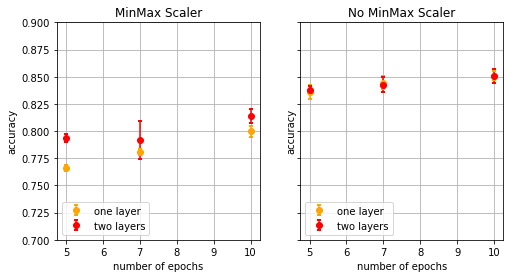

In [138]:
# TO HIDE

def plot_one_set(data, ax, color, label, title):
    """
    plots one set of results.
    """
    ax.errorbar(data['param_classifier__epochs'], 
                data['mean_test_score'], 
                yerr = data['std_test_score'],
                label = label,
                fmt = 'o', color = color, 
                capthick = 2, capsize = 2)

    ax.legend(loc = 3)
    ax.set_ylim((0.7, 0.9))
    ax.grid(True); ax.set_xlabel("number of epochs"); ax.set_ylabel("accuracy")
    ax.set_title(title)
    
# no, I won't use seaborn
fig, axes = plt.subplots(1, 2, sharey = True)
fig.set_size_inches(8, 4)

# with minmax
plot_one_set(res1.loc[res1['layer_type'] == 0], axes[0], 'orange', 'one layer', 'MinMax Scaler')
plot_one_set(res1.loc[res1['layer_type'] == 1], axes[0], 'red', 'two layers', 'MinMax Scaler')

# without minmax
plot_one_set(res2.loc[res2['layer_type'] == 0], axes[1], 'orange', 'one layer', 'No Minmax Scaler')
plot_one_set(res2.loc[res2['layer_type'] == 1], axes[1], 'red', 'two layers', 'No MinMax Scaler')

plt.show()

## Summary

We have created a data pipeline that transforms and classifies the climate data set. Most of the work consisted of writing wrappers around existing `sklearn` and `tensorflow` utilities.

Neaural network classifiers have also been trained and their performance examined. It has been established the range of the input data has a significant impact on the accuracy of the the classifiers.  